# Topic 8: Simulating bias for testing mitigation models and fairness

The project aims to simulate bias in data and evaluate how machine learning models trained on biased data behave. Additionally, it will assess different methods to mitigate bias and improve the fairness of the model’s predictions. The main focus is to understand the impact of biased data on a machine learning system and how fairness interventions affect outcomes.


## Imports

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#from fairlearn.datasets import fetch_adult


import warnings
warnings.filterwarnings('ignore')

## Bias In Data


### Bias in Data and its Simulation

In machine learning (ML), bias refers to systematic errors in data that can lead to unfair decisions. Simulating bias involves generating synthetic datasets that replicate these errors, allowing researchers to analyze the impact of bias on model performance and fairness. Through these simulations, researchers can develop methods to mitigate bias, ensuring fairness and accuracy in decision-making processes.

Bias can appear at various stages of the ML pipeline, from data collection to model deployment. If left unchecked, these biases can perpetuate societal inequalities. Simulating bias helps explore its consequences in controlled scenarios, providing insights into how different types of bias affect both fairness and model accuracy.

### Four Fundamental Types of Bias
1. **Historical Bias**: This type of bias occurs when societal inequalities are reflected in the data. For example, differences in income between genders can reflect past injustices, embedding unfair patterns in the data.
2. **Measurement Bias**: Arises when a proxy variable, instead of the true value, is used in decision-making. For example, using IQ tests as a proxy for intelligence may introduce bias if the tests favor certain groups.
3. **Representation Bias**: Happens when a specific subgroup (e.g., based on ethnicity or gender) is underrepresented or misrepresented in the data, leading to biased outcomes.
4. **Omitted Variable Bias**: Occurs when an important variable is omitted, resulting in a model that depends on other variables, potentially correlating with sensitive attributes.

### Mathematical Explanation of Bias

We model the relationships between variables and simulate bias using the following equations:

- Let X represent the feature set, and Y be the target variable. The relationship between these variables can be expressed as: Y = f(X) + ε
  where f(X) is the function describing the relationship between features and the target, and ε represents noise.

Different types of bias affect this system in various ways:

- **Historical Bias**: Occurs when a sensitive attribute A impacts both the features X and the target Y. For example: X = g(X) - βh A where βh is the parameter that determines the strength of historical bias.

- **Measurement Bias**: When proxies \( Px \) and \( Py \) are observed instead of true values X and Y, and these proxies are affected by sensitive attributes:
  \[
  Px = X - βm A + N_Px
  \]
  Here, βm is the measurement bias parameter, and N_Px represents random noise affecting the proxy variable.

- **Representation Bias**: This bias can be modeled by undersampling a subgroup of individuals with a sensitive attribute A = 1. The proportion of the undersampled group can be represented as Pu, the undersampling parameter.

- **Omitted Variable Bias**: This occurs when an important feature is missing. For instance, omitting R from the model and using only X could result in spurious dependencies on the sensitive attribute A.

By adjusting the parameters βh, βm, and Pu, we can simulate various types of bias and examine their effects on fairness and model performance.


### Bias Simulation

In [41]:
def create_synth(var_config):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split

    dim = var_config.get('dim')
    print(dim)

    thr_supp = 1  # Threshold correlation for discarding features too correlated with sensitive attributes

    task_type = var_config.get('task_type', 'classification')
    num_classes = var_config.get('num_classes', 2)  # Default to binary classification

    Pu = 1  # Percentage of undersampling instance with A=1

    l_r_q = 0  # Lambda coefficient that quantifies the influence from R to Q
    sy = 1  # Standard deviation of the noise of Y

    # Values to generate R (Primary Variable)
    R_config = var_config.get('R', [{}])[0]
    R_mean = R_config.get('mean', 0)  # Default mean is 0 if not found
    R_std = R_config.get('std', 1)  # Default std is 1 if not found
    R_func = R_config.get('func', 'normal')  # Default function is normal if not found

    if R_func == 'normal':
        R = np.random.normal(R_mean, R_std, dim)
    elif R_func == 'uniform':
        R = np.random.uniform(R_mean, R_std, dim)
    elif R_func == 'binomial':
        R = np.random.binomial(R_mean, R_std, dim)

    # Remap R to fit the min and max values defined in the config
    r_max = R_config.get('max', 1)
    r_min = R_config.get('min', 0)
    R = (R - R.min()) / (R.max() - R.min())
    R = R * (r_max - r_min) + r_min

    # Create y_real as a direct, unbiased transformation of R
    y_real = R.copy()

    # Create variable A (sensitive attributes)
    A_vars = {}
    for var in var_config.get('A', []):
        A_vars[var['name']] = np.random.normal(0, 3, dim)
        if var['binary']:
            A_vars[var['name']] = np.random.binomial(1, 0.5, dim)
        else:
            A_vars[var['name']] = np.random.normal(0, 3, dim)

    # Modify R based on historical bias from A
    N1 = R.copy()
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        N1 -= var['hist_bias'] * A_var

    # Create variable Q (auxiliary features)
    Q_vars = {}
    for var in var_config.get('Q', []):
        Q_func = var.get('func', 'normal')
        if Q_func == 'normal':
            Q_vars[var['name']] = np.random.normal(0, 3, dim)
        elif Q_func == 'uniform':
            Q_vars[var['name']] = np.random.uniform(0, 3, dim)
        elif Q_func == 'binomial':
            Q_vars[var['name']] = np.random.binomial(1, 0.5, dim)

    # Generate y with all biases applied
    y = N1.copy()
    Ny = np.random.normal(0, sy, dim)
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        A_hist_bias = var['hist_bias']
        A_meas_bias = var['meas_bias']
        y -= A_hist_bias * A_var + A_meas_bias * A_var * (N1 < np.median(N1)) - A_meas_bias * A_var * (N1 >= np.median(N1))

    for var in var_config.get('Q', []):
        Q_var = Q_vars[var['name']]
        y -= var['importance'] * (Q_var + var['hist_bias'])

    y += Ny  # Add noise to y

    # Remap y to fit the range defined in R config
    y = (y - y.min()) / (y.max() - y.min())
    y = y * (r_max - r_min) + r_min

    # Adjust for classification or regression
    if task_type == 'classification':
        thresholds = np.linspace(y.min(), y.max(), num_classes + 1)[1:-1]
        y = np.digitize(y, bins=thresholds)
        y_real = np.digitize(y_real, bins=thresholds)


    # Assemble the dataset
    data = {'R': R, 'Y': y, 'Y_real': y_real}
    data.update(A_vars)
    data.update(Q_vars)

    dtf = pd.DataFrame(data)

    # Undersample instances where A == 1
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        A_undersample_rate = var.get('undersampling_rate', 0)

        if A_undersample_rate > 0:
            # Identify the rows in the current DataFrame corresponding to A == 1
            A_indices = dtf.index[dtf[var['name']] == 1]
            A_indices_to_drop = np.random.choice(A_indices, int(A_undersample_rate * len(A_indices)), replace=False)
            dtf.drop(A_indices_to_drop, inplace=True)

    # Define feature matrix X and target Y
    X = dtf.reset_index(drop=True)
    y = X['Y']
    y_real = X['Y_real']
    del X['Y']
    del X['Y_real']

    # Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, stratify=X[list(A_vars.keys())[0]] if task_type == 'classification' else None)

    # Create individual and suppression sets
    X_ind_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys())]]
    X_ind_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys())]]

    X_supp_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys()) and
                            abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]
    X_supp_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys()) and
                          abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]

    # Return the generated dataset and variables
    y_train_real = y_real[y_train.index]
    y_test_real = y_real[y_test.index]

    return X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real


In [42]:
dim = 3000 # Dimension of the dataset

vars = {
    'dim' : dim,
    # R is the main variable that represetns the target variable (normal, uniform, binomial)
    # after bias application, values get mapped in the same distribution to fit the min/max interval, in the same ratio
    'R': [
        {'Name': 'R1', 'mean': 100, 'std': 50, 'function': 'binomial', 'min': 40000, 'max': 85000},
    ],
    # A is a group of variables that influence the target variable through historical bias.
    # It can have measurement bias and be used to represent undersamlped instances.
    'A': [
        {'name': 'A1', 'hist_bias': 10, 'meas_bias': 10, 'undersampling_rate': 0, 'binary': True},
        {'name': 'A2', 'hist_bias': 50, 'meas_bias': 10, 'undersampling_rate': 0.5, 'binary': True},
        {'name': 'A3', 'hist_bias': 1000, 'meas_bias': 10, 'undersampling_rate': 0.9, 'binary': True},
    ],
    # Q is a group of variables that can or not influence the target variable, depending on the importance. (normal, uniform, binomial)
    'Q': [
        {'name': 'Q1', 'importance': 50, 'hist_bias': 10, 'func': 'normal'},
        {'name': 'Q2', 'importance': 150, 'hist_bias': 50, 'func': 'uniform'},
    ],
    # P is a group of variables that are used as proxies for the target variable, value is usually random.
    'P': [
        {'name': 'P1', 'proxy_val': np.random.normal(0, 2, dim), 'meas_bias': 1},
    ],
}

X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real = create_synth(vars)

3000


In [98]:
dim = 3000  # Dimension of the dataset

vars = {
    'dim': dim,
    'task_type': 'classification',  # Specify the task type as classification
    'num_classes': 2,  # Binary classification: Approved (1) or Denied (0)
    
    # R represents the customer's creditworthiness score, which is the primary variable affecting the loan decision.
    'R': [
        {'Name': 'Creditworthiness', 'mean': 650, 'std': 100, 'func': 'normal', 'min': 300, 'max': 850},
    ],
    
    # A group of demographic factors with historical bias that influence loan decisions.
    'A': [
        {'name': 'IncomeBracket', 'hist_bias': 15, 'meas_bias': 10, 'undersampling_rate': 0.2, 'binary': True},  # Income bracket (low-income vs. high-income)
        {'name': 'Gender', 'hist_bias': 100, 'meas_bias': 5, 'undersampling_rate': 0.5, 'binary': True},  # Gender bias
        {'name': 'MinorityStatus', 'hist_bias': 120, 'meas_bias': 20, 'undersampling_rate': 0.7, 'binary': True},  # Minority group status
    ],
    
    # Q represents additional features like credit history, debt-to-income ratio, etc., which indirectly influence the loan decision.
    'Q': [
        {'name': 'CreditHistoryLength', 'importance': 25, 'hist_bias': 5, 'func': 'normal'},  # Credit history length
        {'name': 'DebtToIncomeRatio', 'importance': 60, 'hist_bias': 10, 'func': 'uniform'},  # Debt-to-income ratio
    ],
    
    # P includes proxy variables such as "Neighborhood," which may unintentionally reflect socioeconomic biases.
    'P': [
        {'name': 'NeighborhoodScore', 'proxy_val': np.random.normal(0, 2, dim), 'meas_bias': 2},
    ],
}

X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real = create_synth(vars)

3000


In [99]:
X_train.to_csv('data/X_train.csv', index=False)
X_ind_train.to_csv('data/X_ind_train.csv', index=False)
X_supp_train.to_csv('data/X_supp_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
X_ind_test.to_csv('data/X_ind_test.csv', index=False)
X_supp_test.to_csv('data/X_supp_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)
y_train_real.to_csv('data/y_train_real.csv', index=False)
y_test_real.to_csv('data/y_test_real.csv', index=False)

In [100]:
# mame X_train and y_train into df

df = pd.concat([X_train, y_train], axis=1)

# sns.pairplot(X_train)
# plt.show()

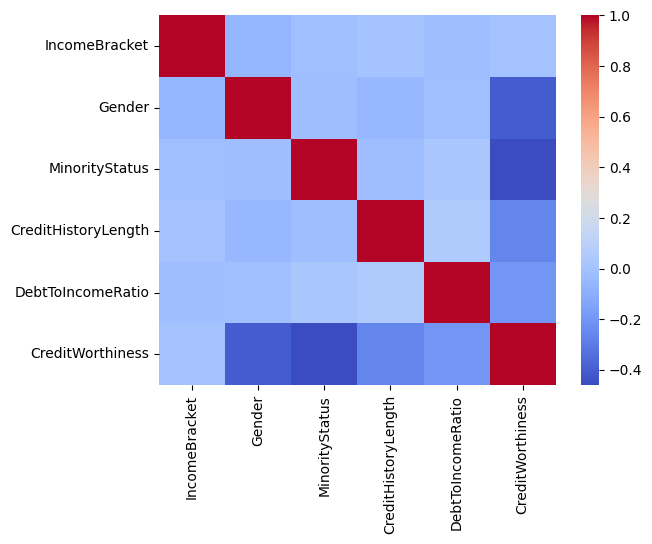

In [101]:
X_train['CreditWorthiness'] = y_train
X_train.drop('R', axis=1, inplace=True) if 'R' in X_train.columns else None
sns.heatmap(X_train.corr(), fmt=".2f", cmap='coolwarm')
plt.show()
X_train.drop('CreditWorthiness', axis=1, inplace=True)

In [102]:
# # plot barplot value counts of A1, A2, A3
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.barplot(x=X_train['A1'].value_counts().index, y=X_train['A1'].value_counts().values, ax=ax[0])
# sns.barplot(x=X_train['A2'].value_counts().index, y=X_train['A2'].value_counts().values, ax=ax[1])
# sns.barplot(x=X_train['A3'].value_counts().index, y=X_train['A3'].value_counts().values, ax=ax[2])

# plt.show()

In [103]:
# # print average Y per A variable
# print('A1 mean Y:', df.groupby('A1')['Y'].mean())
# print('A2 mean Y:', df.groupby('A2')['Y'].mean())
# print('A3 mean Y:', df.groupby('A3')['Y'].mean())

## Bias Mitigation and Fairness

In [30]:
# from FLAI import data
# from FLAI import causal_graph
# import pandas as pd

In [31]:
# df.head()

,R,A1,A2,A3,Q1,Q2,P1,Y
1176,75369.606151,0,1,0,-2.743546,1.286334,14.545330,78053.464169
213,78799.874267,0,0,0,4.866539,0.111292,122.114601,76580.856094
99,78405.198118,1,0,0,1.467708,0.468715,110.158740,78138.439897
577,76753.346752,1,0,0,-3.062825,1.632106,51.943256,78886.401451
900,78386.960597,0,0,0,1.570824,1.383991,108.428910,76912.201609


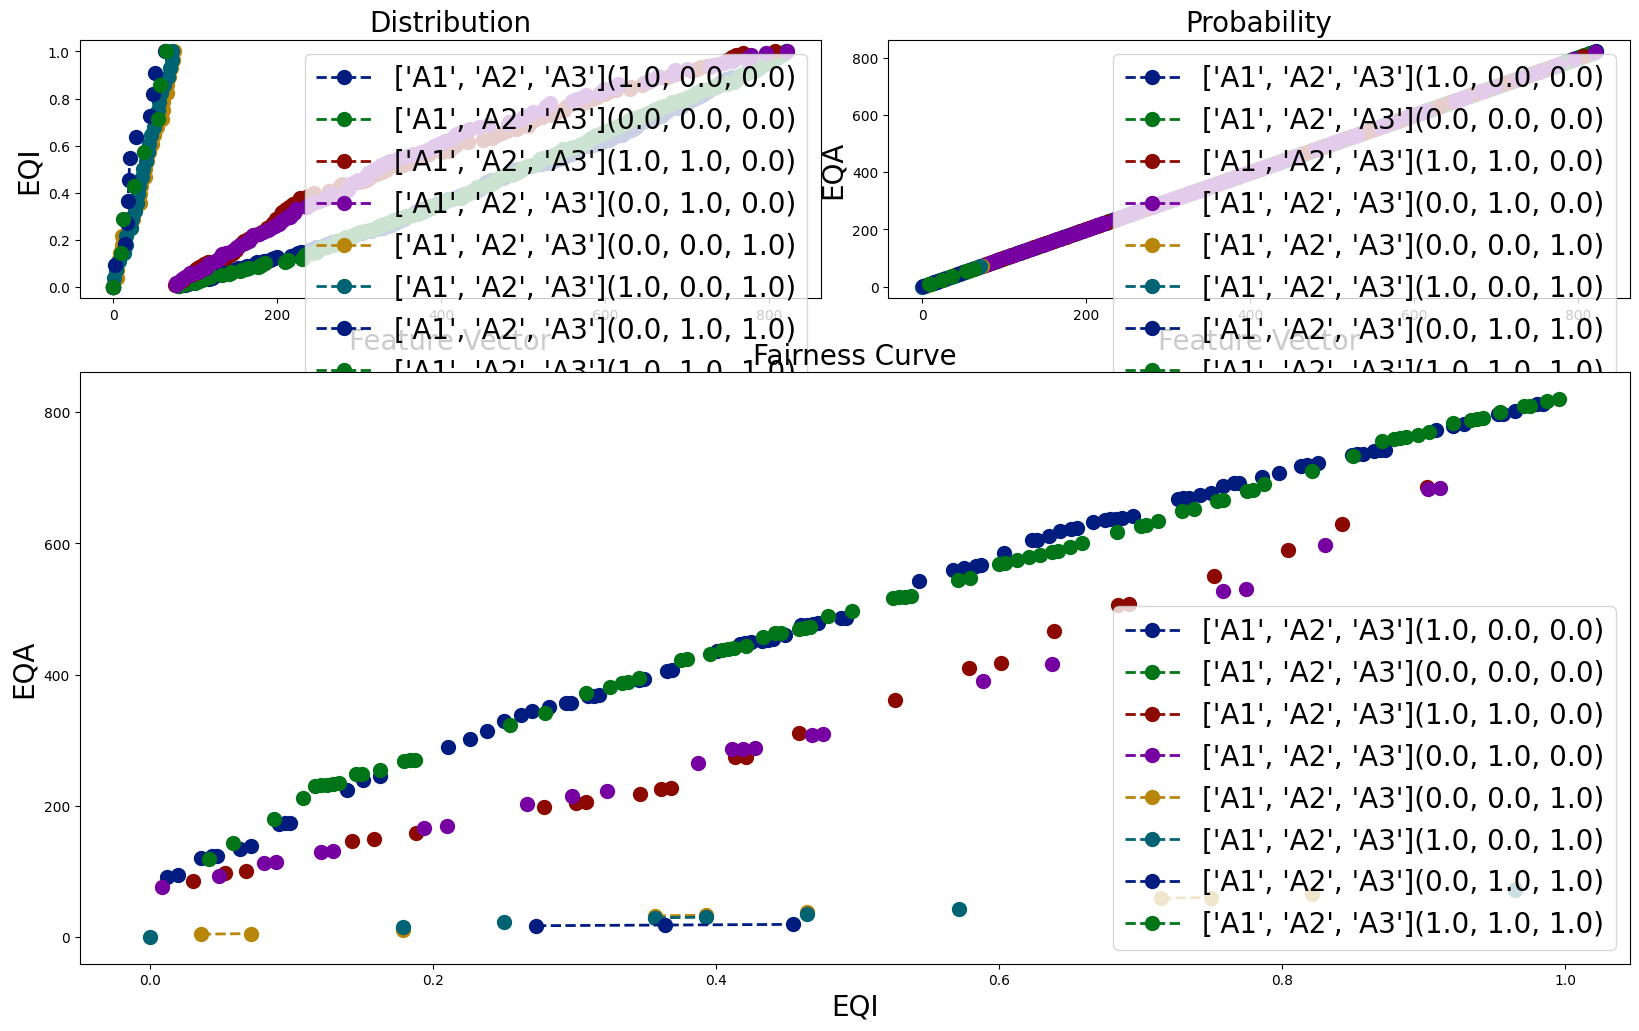

In [32]:
flai_dataset = data.Data(df, transform=True)

df_f,datos_f = flai_dataset.fairness_eqa_eqi(features = ['Q1'], 
                              target_column = 'Y', 
                              column_filter = ['A1', 'A2', 'A3'],
                              plot = True)

#### Biased Model Creation

In [104]:
#logistic reg
from sklearn.linear_model import LinearRegression
X_train.drop('R', axis=1, inplace=True) if 'R' in X_train.columns else None

model = LinearRegression()

model.fit(X=X_train, y=y_train)

X_test.drop('R', axis=1, inplace=True) if 'R' in X_test.columns else None
y_pred = model.predict(X_test)

from sklearn.metrics import median_absolute_error

print("Median Absolute Error on Biased: " + str(median_absolute_error(y_test, y_pred)))
print("Median Absolute Error on Real: " + str(median_absolute_error(y_test_real, y_pred)))


Median Absolute Error on Biased: 0.20161520097836494
Median Absolute Error on Real: 0.411039324948386


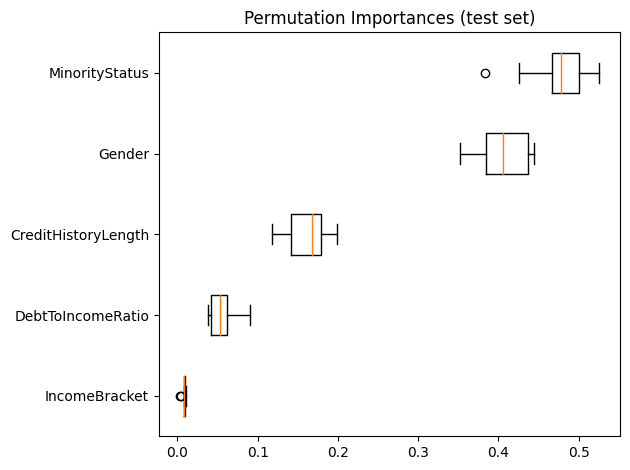

In [105]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [106]:

for feature in X_test.columns:
    try:
        print("Feature: " + feature)
        X_test_feature = X_test[X_test[feature] == 0]
        y_test_feature = y_test[X_test_feature.index]
        y_pred_feature = model.predict(X_test_feature)
        print("Median Absolute Error on Biased " + feature + ": " + str(median_absolute_error(y_test_feature, y_pred_feature)))
        print("Median Absolute Error on Real " + feature + ": " + str(median_absolute_error(y_test_real[X_test_feature.index], y_pred_feature)))
    except:
        print("NA")
        pass

Feature: IncomeBracket
Median Absolute Error on Biased IncomeBracket: 0.17352495195579165
Median Absolute Error on Real IncomeBracket: 0.3763542825763076
Feature: Gender
Median Absolute Error on Biased Gender: 0.1226975176545807
Median Absolute Error on Real Gender: 0.25482702784859024
Feature: MinorityStatus
Median Absolute Error on Biased MinorityStatus: 0.1512521451521024
Median Absolute Error on Real MinorityStatus: 0.32455242669179096
Feature: CreditHistoryLength
NA
Feature: DebtToIncomeRatio
NA


In [107]:
z = X_train['Gender']
X_train.drop('Gender', axis=1, inplace=True) 
pos_label = 0

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X_train, y_train, z, test_size=0.33, random_state=42)

In [108]:
import sklearn
from numpy import number
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sklearn.set_config(enable_metadata_routing=True)

ct = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean")),
                ("normalizer", StandardScaler()),
            ]
        ),
        make_column_selector(dtype_include=number),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)

In [109]:
from fairlearn.adversarial import AdversarialFairnessClassifier

mitigator = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[50, "leaky_relu"],
    adversary_model=[3, "leaky_relu"],
    batch_size=2**8,
    progress_updates=0.5,
    random_state=123,
)

In [110]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ct, mitigator.set_fit_request(sensitive_features=True))

In [111]:
pipeline.fit(X_train, y_train, sensitive_features=Z_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026A7F36A200>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026A7F36A080>)])),
                ('adversarialfairnessclassifier',
                 AdversarialFairnessClassifier(adversary_model=[3,
                                                                'leaky_relu'],
                                               backend='torch', batch_size=256,
                                               predictor_model=[50,
                                                                'leaky_relu'],
                                               progress_updates=0.5,
                                               random_state=123))])

In [112]:
predictions = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score

from fairlearn.metrics import MetricFrame, selection_rate

mf = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true = y_test == pos_label,
    y_pred = predictions == pos_label,
    sensitive_features=Z_test,
)

In [113]:
print(mf.by_group)

        accuracy  selection_rate
Gender                          
0       0.345745        0.606383
1       0.353535        0.666667


In [114]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')

y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_test_real = pd.read_csv('data/y_test_real.csv')
y_train_real = pd.read_csv('data/y_train_real.csv')


In [115]:
from fairlearn.preprocessing import CorrelationRemover
# binary classification model
from sklearn.tree import DecisionTreeClassifier

X_train.drop('R', axis=1, inplace=True) if 'R' in X_train.columns else None
X_test.drop('R', axis=1, inplace=True) if 'R' in X_test.columns else None

remover = CorrelationRemover(sensitive_feature_ids=['Gender'])
remover_df = remover.fit_transform(X_train, y_train)

#apply transformation to test set
X_test_corr = remover.transform(X_test)
model_corr = DecisionTreeClassifier()

model_corr.fit(X=remover_df, y=y_train)

y_pred_corr = model_corr.predict(X_test_corr)
y_pred_binary = (y_pred_corr > 0.5).astype(int)
y_pred_not_real_binary = (y_pred > 0.5).astype(int)


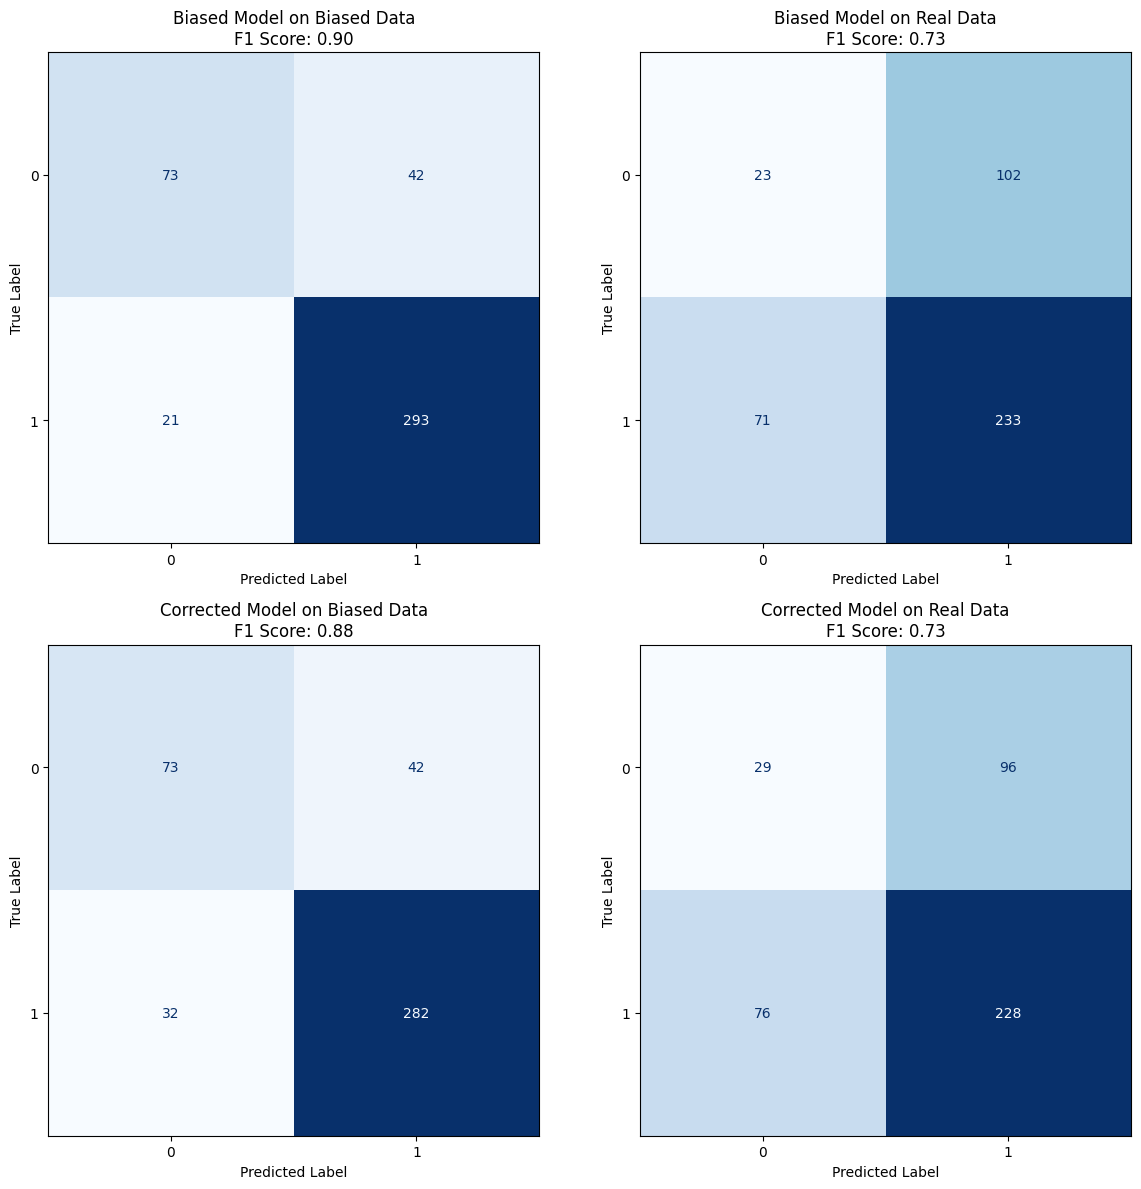

In [116]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Results dictionary to store F1 scores
results = {}
combinations = [
    ("Biased Model on Biased Data", y_test, y_pred_not_real_binary),
    ("Biased Model on Real Data", y_test_real, y_pred_not_real_binary),
    ("Corrected Model on Biased Data", y_test, y_pred_binary),
    ("Corrected Model on Real Data", y_test_real, y_pred_binary),
]

# Calculate F1 scores for each combination
for name, true_y, pred_y in combinations:
    results[name] = f1_score(true_y, pred_y)

# Convert results to a DataFrame
results_df = pd.DataFrame(
    list(results.items()),
    columns=["Combination", "F1 Score"]
)

# Plotting confusion matrices for each combination
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, (name, true_y, pred_y) in enumerate(combinations):
    cm = confusion_matrix(true_y, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{name}\nF1 Score: {results[name]:.2f}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [39]:
import shap

## References

**Baumann, Joachim**, **Castelnovo, Alessandro**, **Crupi, Riccardo**, **Inverardi, Nicole**, and **Regoli, Daniele**. 2023. **Bias on Demand: A Modelling Framework That Generates Synthetic Data With Bias**. *In Proceedings of the 2023 ACM Conference on Fairness, Accountability, and Transparency*. [https://doi.org/10.1145/3593013.3594058](https://doi.org/10.1145/3593013.3594058).
